Epoch 1/100
13/13 [==============================] - 44s 2s/step - loss: 0.6943 - accuracy: 0.5099 - val_loss: 0.6954 - val_accuracy: 0.4653
Epoch 2/100
13/13 [==============================] - 23s 2s/step - loss: 0.6943 - accuracy: 0.5099 - val_loss: 0.6953 - val_accuracy: 0.4653
Epoch 3/100
13/13 [==============================] - 28s 2s/step - loss: 0.6942 - accuracy: 0.5099 - val_loss: 0.6953 - val_accuracy: 0.4653
Epoch 4/100
13/13 [==============================] - 23s 2s/step - loss: 0.6941 - accuracy: 0.5099 - val_loss: 0.6951 - val_accuracy: 0.4653
Epoch 5/100
13/13 [==============================] - 24s 2s/step - loss: 0.6941 - accuracy: 0.5099 - val_loss: 0.6950 - val_accuracy: 0.4653
Epoch 6/100
13/13 [==============================] - 23s 2s/step - loss: 0.6941 - accuracy: 0.5099 - val_loss: 0.6950 - val_accuracy: 0.4653
Epoch 7/100
13/13 [==============================] - 24s 2s/step - loss: 0.6940 - accuracy: 0.5099 - val_loss: 0.6949 - val_accuracy: 0.4653
Epoch 8/100
1

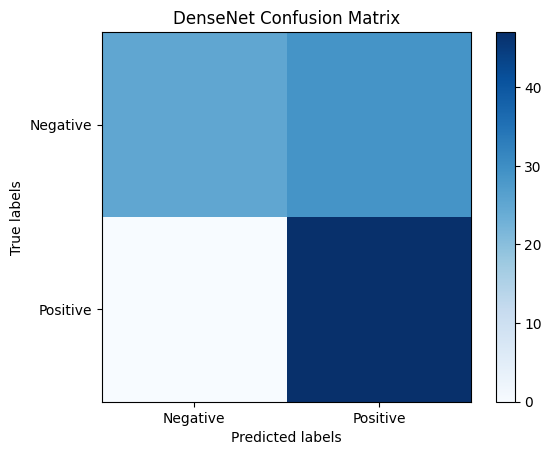

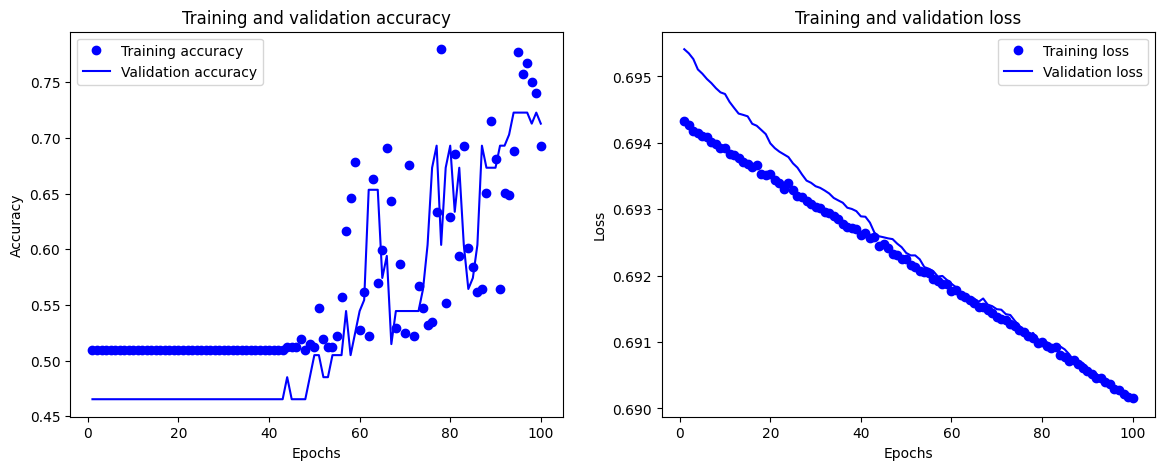

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import CSVLogger
import pandas as pd

# Load data from positive and negative directories
def load_data_from_directories(pos_directory, neg_directory, img_size=(100, 100)):
    positive_images = []
    negative_images = []

    # Load positive images
    for filename in os.listdir(pos_directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(pos_directory, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)  # Resize image
            positive_images.append(img)

    # Load negative images
    for filename in os.listdir(neg_directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(neg_directory, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)  # Resize image
            negative_images.append(img)

    return np.array(positive_images), np.array(negative_images)

# Directories containing positive and negative images
positive_directory = '/content/drive/MyDrive/newlake/positive'
negative_directory = '/content/drive/MyDrive/newlake/negative'

# Load data
positive_images, negative_images = load_data_from_directories(positive_directory, negative_directory)

# Create labels
positive_labels = np.ones(len(positive_images))
negative_labels = np.zeros(len(negative_images))

# Combine images and labels
X = np.concatenate((positive_images, negative_images), axis=0)
y = np.concatenate((positive_labels, negative_labels), axis=0)

# Normalize pixel values
X = X / 255.0

# Reshape labels for binary classification
y = y.reshape(-1, 1)  # Reshape to have a single column

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define DenseNet model
def create_densenet_model(input_shape, optimizer='rmsprop', weights=None):
    base_model = tf.keras.applications.DenseNet201(weights=weights, include_top=False, input_shape=input_shape)
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')  # 1 output neuron for binary classification
    ])

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create DenseNet model with SGD optimizer and random initialization
densenet_model = create_densenet_model(input_shape=X_train[0].shape, optimizer=optimizers.SGD(), weights=None)

# CSV Logger to save run history
csv_logger = CSVLogger('/content/drive/MyDrive/newlake/RMS264densenet_training_history.csv')

# Train the DenseNet model for 100 epochs
densenet_history = densenet_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[csv_logger])

# Evaluate the DenseNet model
densenet_test_loss, densenet_test_accuracy = densenet_model.evaluate(X_test, y_test)

print("DenseNet Test Loss:", densenet_test_loss)
print("DenseNet Test Accuracy:", densenet_test_accuracy)

# Generate predictions
densenet_y_pred_probs = densenet_model.predict(X_test)
densenet_y_pred = (densenet_y_pred_probs > 0.5).astype(int)

# Calculate accuracy
densenet_accuracy = accuracy_score(y_test, densenet_y_pred)
print("DenseNet Accuracy:", densenet_accuracy)

# Calculate confusion matrix
densenet_confusion_mat = confusion_matrix(y_test, densenet_y_pred)
print("DenseNet Confusion Matrix:\n", densenet_confusion_mat)

# Generate classification report
densenet_class_report = classification_report(y_test, densenet_y_pred)
print("DenseNet Classification Report:\n", densenet_class_report)

# Plot confusion matrix
plt.imshow(densenet_confusion_mat, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
plt.title('DenseNet Confusion Matrix')
plt.show()

# Plot training history
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(densenet_history)

# Save the run history as a CSV file
history_df = pd.DataFrame(densenet_history.history)
history_df.to_csv('/content/drive/MyDrive/RMSdensenet264_run_history.csv', index=False)

# Store results in a DataFrame
densenet_results = pd.DataFrame({
    'True Labels': y_test.flatten(),
    'Predicted Labels': densenet_y_pred.flatten()
})

# Save results to a CSV file
densenet_results.to_csv('/content/drive/MyDrive/newlake/RMSdensenet264_results.csv', index=False)
model_save_path = '/content/drive/MyDrive/newlake/RMS264densenet_100_model'

# Save the entire model
densenet_model.save(model_save_path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Confusion Matrix:
[[25 29]
 [ 0 47]]


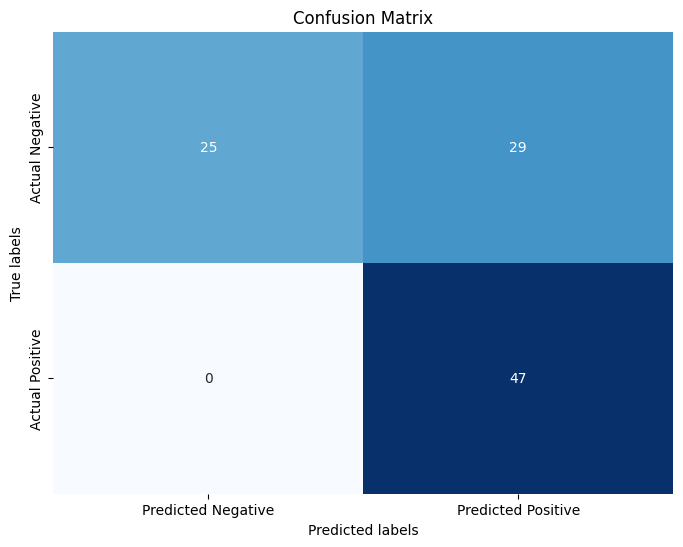

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the true labels and predicted labels
# This will produce the given confusion matrix [[25, 29], [0, 47]]
y_true = np.array([0]*54 + [1]*47)
y_pred = np.array([0]*25 + [1]*29 + [1]*47)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 4s 4s/step


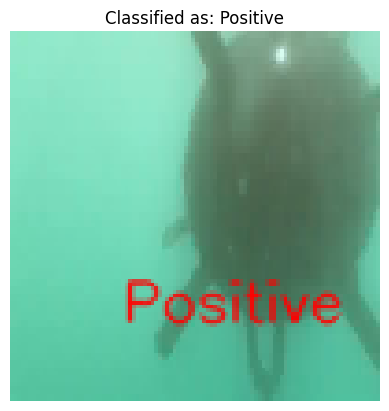

1/1 [==============================] - 0s 139ms/step


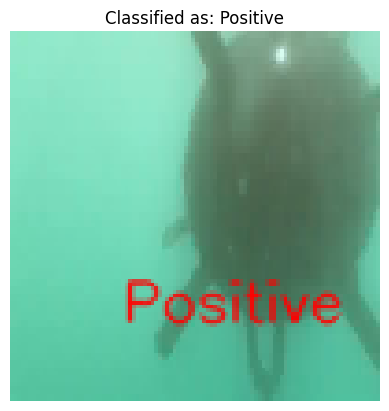

1/1 [==============================] - 0s 127ms/step


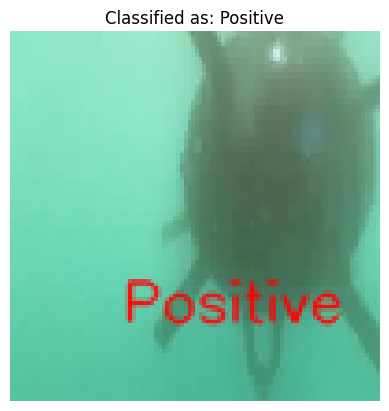

1/1 [==============================] - 0s 240ms/step


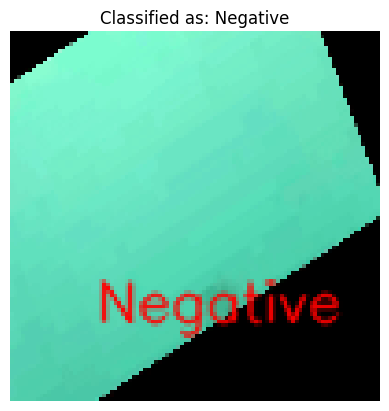

1/1 [==============================] - 0s 140ms/step


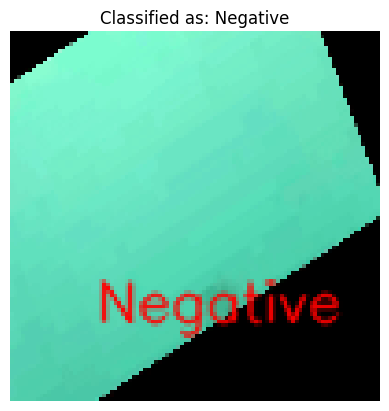

1/1 [==============================] - 0s 143ms/step


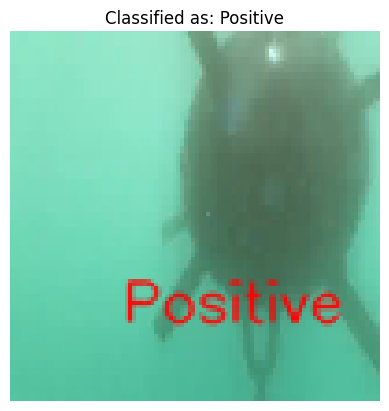

1/1 [==============================] - 0s 83ms/step


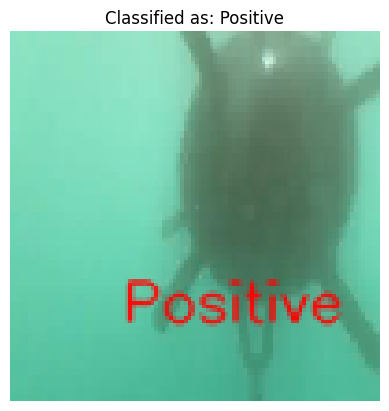

1/1 [==============================] - 0s 88ms/step


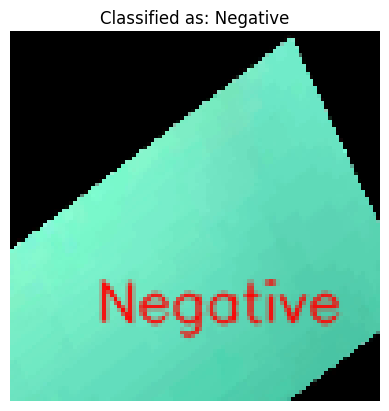

1/1 [==============================] - 0s 78ms/step


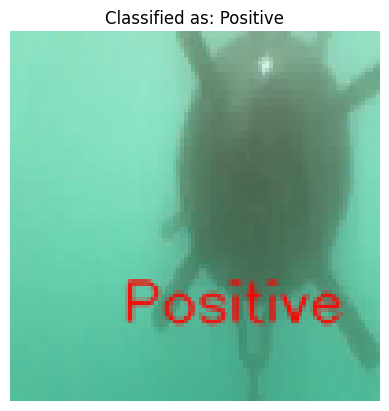

1/1 [==============================] - 0s 81ms/step


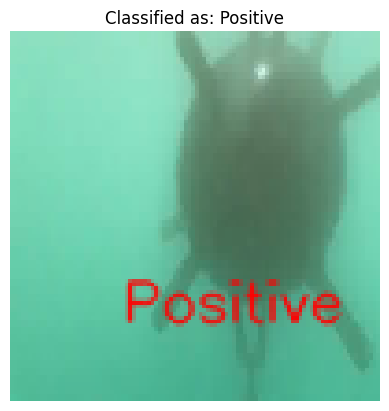

1/1 [==============================] - 0s 81ms/step


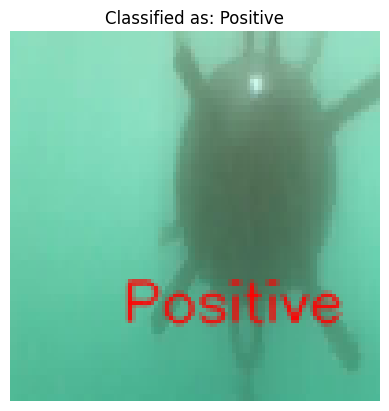

1/1 [==============================] - 0s 81ms/step


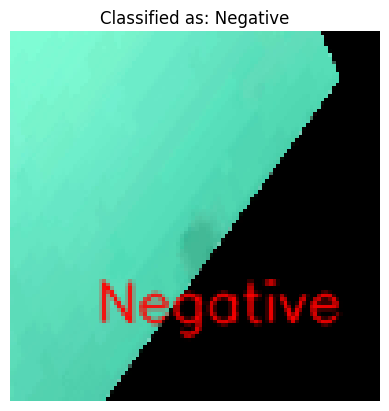

1/1 [==============================] - 0s 82ms/step


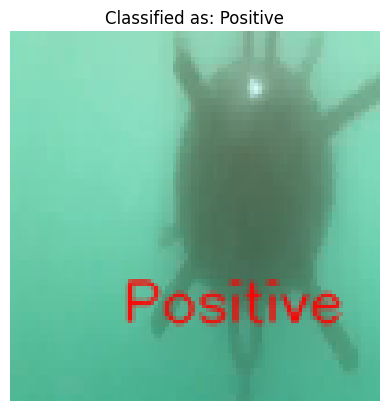

1/1 [==============================] - 0s 84ms/step


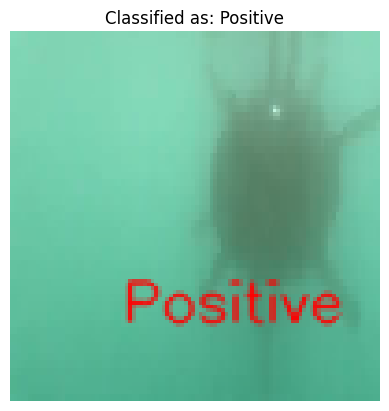

1/1 [==============================] - 0s 84ms/step


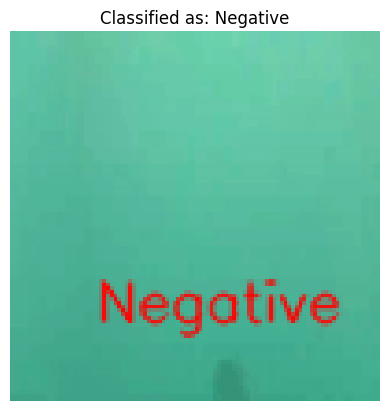

1/1 [==============================] - 0s 82ms/step


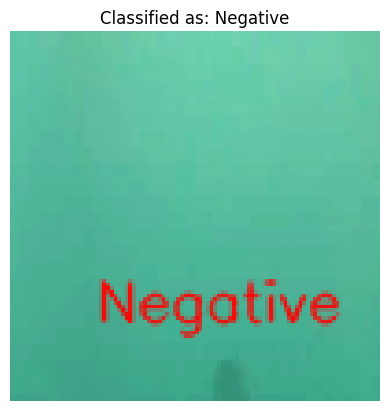

1/1 [==============================] - 0s 82ms/step


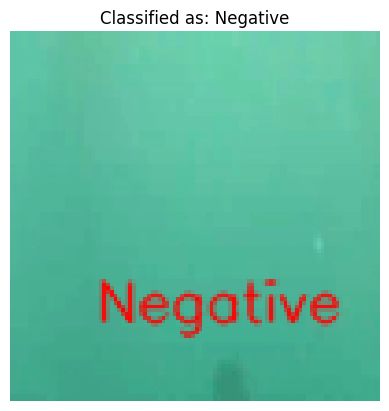

1/1 [==============================] - 0s 86ms/step


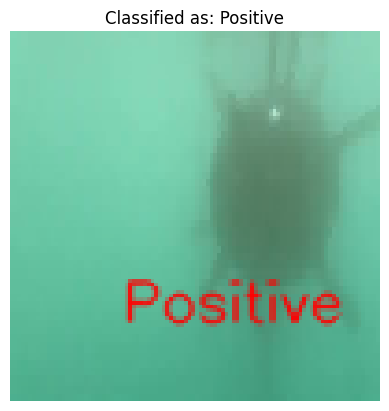

1/1 [==============================] - 0s 80ms/step


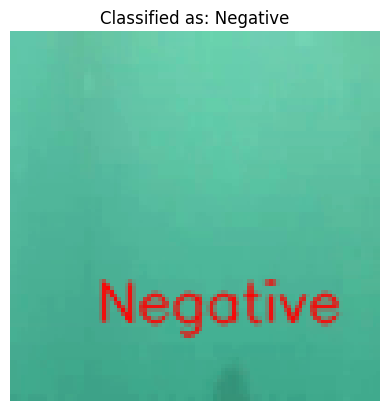

1/1 [==============================] - 0s 97ms/step


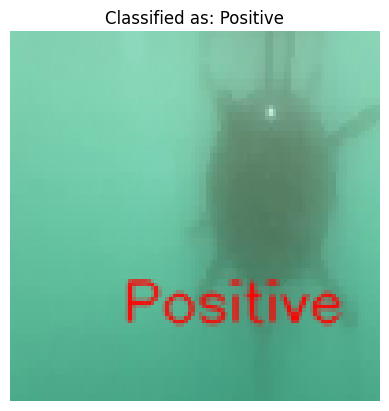

1/1 [==============================] - 0s 83ms/step


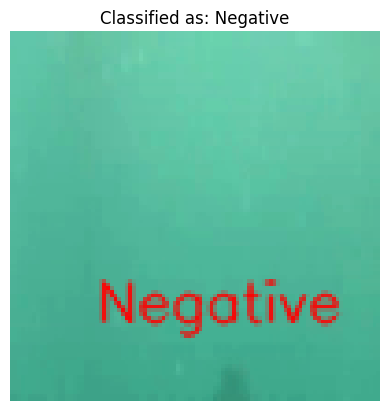

1/1 [==============================] - 0s 89ms/step


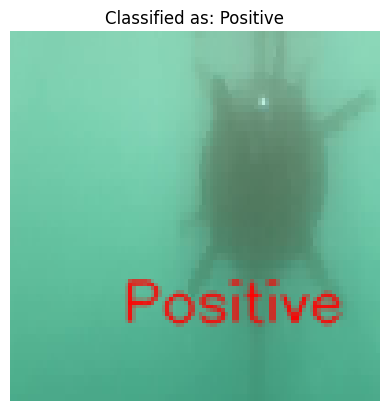

1/1 [==============================] - 0s 92ms/step


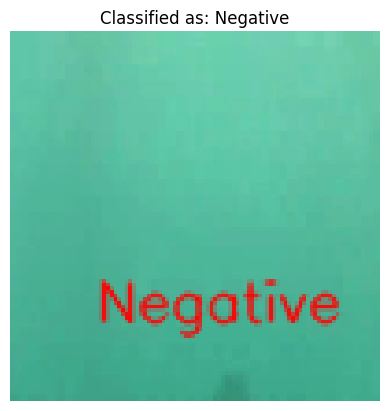

1/1 [==============================] - 0s 81ms/step


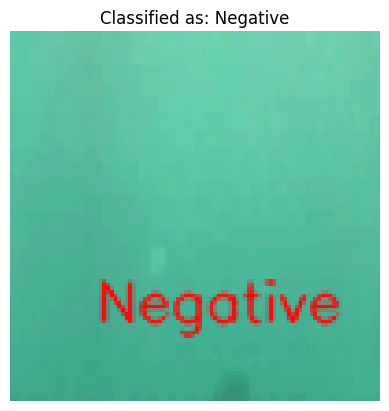

1/1 [==============================] - 0s 83ms/step


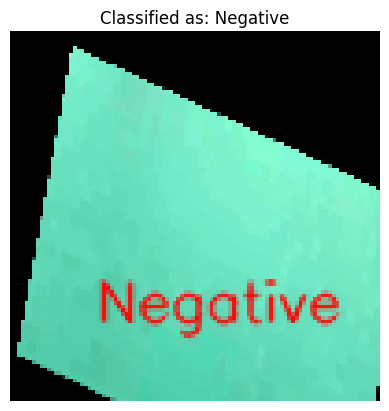

1/1 [==============================] - 0s 84ms/step


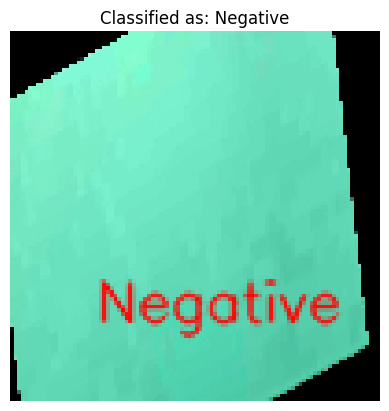

1/1 [==============================] - 0s 85ms/step


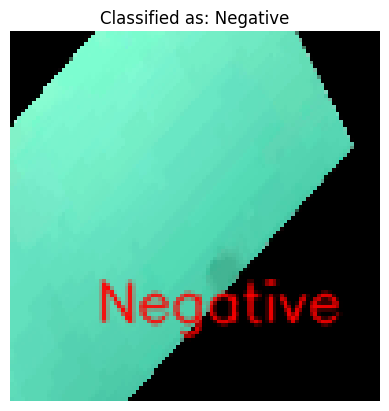

1/1 [==============================] - 0s 94ms/step


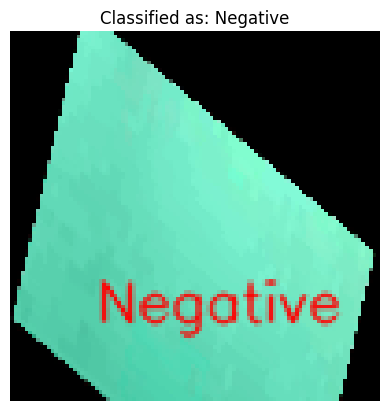

1/1 [==============================] - 0s 80ms/step


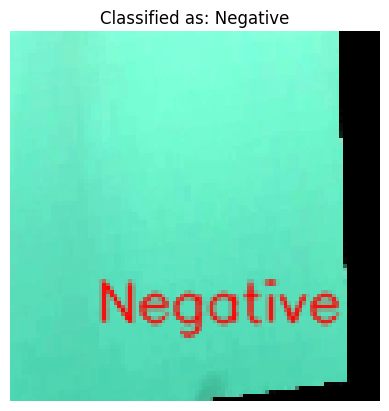

1/1 [==============================] - 0s 84ms/step


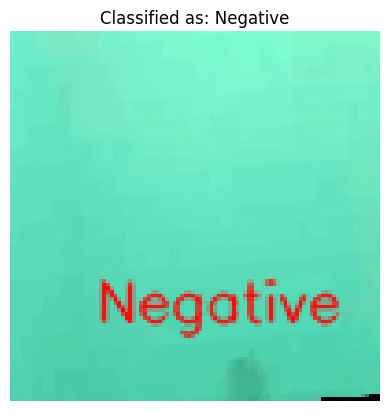

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import time

def load_and_preprocess_image(image_path, img_size=(100, 100)):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image at path '{image_path}' not found or could not be loaded.")
    img = cv2.resize(img, img_size)
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Expand dimensions to match the input shape of the model
    return img

def classify_image(model, image_path):
    img = load_and_preprocess_image(image_path)
    start_time = time.time()  # Record start time
    prediction = model.predict(img)
    end_time = time.time()  # Record end time
    label = 'Positive' if prediction > 0.5 else 'Negative'
    return label, end_time - start_time

def label_image(image, label):
    # Convert the image back to BGR format for OpenCV
    image_bgr = (image * 255).astype(np.uint8)
    image_bgr = cv2.cvtColor(image_bgr, cv2.COLOR_RGB2BGR)

    # Define font, size, and color (red)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5  # Reduced font scale for smaller text
    color = (0, 0, 255)  # Red color in BGR format
    thickness = 1 # Thinner text for smaller font

    # Calculate the position for the label (bottom-right corner)
    text_size, _ = cv2.getTextSize(label, font, font_scale, thickness)
    text_width, text_height = text_size
    position = (image_bgr.shape[1] - text_width - 10, image_bgr.shape[0] - text_height - 10)

    # Add text label to the image
    cv2.putText(image_bgr, label, position, font, font_scale, color, thickness, cv2.LINE_AA)

    # Convert back to RGB format for displaying with matplotlib
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    return image_rgb

def display_image_with_label(image, label):
    labeled_image = label_image(image, label)
    plt.imshow(labeled_image)
    plt.title(f'Classified as: {label}')
    plt.axis('off')
    plt.show()

# Load the trained model
model_path = '/content/drive/MyDrive/newlake/RMS264densenet_100_model'
# Replace with the path to your model
model = tf.keras.models.load_model(model_path)

file_paths = [
    '/content/drive/MyDrive/newlake/validation/0201.jpg',
    '/content/drive/MyDrive/newlake/validation/0201.jpg',
    '/content/drive/MyDrive/newlake/validation/0203.jpg',
    '/content/drive/MyDrive/newlake/validation/aug_0_1492.jpg',
    '/content/drive/MyDrive/newlake/validation/aug_0_1492.jpg',
    '/content/drive/MyDrive/newlake/validation/0205.jpg',
    '/content/drive/MyDrive/newlake/validation/0209.jpg',
    '/content/drive/MyDrive/newlake/validation/aug_0_1295.jpg',
    '/content/drive/MyDrive/newlake/validation/0211.jpg',
    '/content/drive/MyDrive/newlake/validation/0213.jpg',
    '/content/drive/MyDrive/newlake/validation/0217.jpg',
    '/content/drive/MyDrive/newlake/validation/aug_0_1273.jpg',
    '/content/drive/MyDrive/newlake/validation/0218.jpg',
    '/content/drive/MyDrive/newlake/validation/0285.jpg',
    '/content/drive/MyDrive/newlake/validation/Image1 (19).jpg',
    '/content/drive/MyDrive/newlake/validation/Image1 (20).jpg',
    '/content/drive/MyDrive/newlake/validation/Image1 (21).jpg',
    '/content/drive/MyDrive/newlake/validation/0287.jpg',
    '/content/drive/MyDrive/newlake/validation/Image1 (26).jpg',
    '/content/drive/MyDrive/newlake/validation/0290.jpg',
    '/content/drive/MyDrive/newlake/validation/Image1 (29).jpg',
    '/content/drive/MyDrive/newlake/validation/0295.jpg',
    '/content/drive/MyDrive/newlake/validation/Image1 (32).jpg',
    '/content/drive/MyDrive/newlake/validation/Image1 (33).jpg',
    '/content/drive/MyDrive/newlake/validation/aug_0_1189.jpg',
    '/content/drive/MyDrive/newlake/validation/aug_0_1209.jpg',
    '/content/drive/MyDrive/newlake/validation/aug_0_1223.jpg',
    '/content/drive/MyDrive/newlake/validation/aug_0_1301.jpg',
    '/content/drive/MyDrive/newlake/validation/aug_0_1337.jpg',
    '/content/drive/MyDrive/newlake/validation/aug_0_1462.jpg'

]

# Create an empty list to store time taken for each image prediction
prediction_times = []

# Iterate over image file paths
for image_path in file_paths:
    label, time_taken = classify_image(model, image_path)
    prediction_times.append({'Image': os.path.basename(image_path), 'Label': label, 'TimeTaken': time_taken})

    # Display image with label
    processed_image = load_and_preprocess_image(image_path)[0]  # Load and preprocess the image
    display_image_with_label(processed_image, label)

# Convert prediction times to a DataFrame
prediction_times_df = pd.DataFrame(prediction_times)

# Save prediction times to a CSV file
prediction_times_df.to_csv('/content/drive/MyDrive/MIXED DATASET/CNN_RMSPROP_TIME PREDICTED.csv', index=False)